#### import some necessary modules and functions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [2]:
# Login onto Hugging Face hub to load any private dataset/model.
# We need to login as we'll also upload our model to the hub
notebook_login()

#### load image classification dataset


In [3]:
dataset = load_dataset('pcuenq/oxford-pets')
dataset

README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

c:\Users\ahsam\anaconda3\envs\dl_env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ahsam\.cache\huggingface\hub\datasets--pcuenq--oxford-pets. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


dataset_infos.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

(…)-00000-of-00001-ecc2afb43dedd5e0.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

#### The dataset contains the following features:

* path: a path to the file
* label: the breed of the animal
* dog: indicates if the animal is a dog or not
* image: a PIL format image

In [4]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>}

In [5]:
labels = dataset['train'].unique('label')
print(len(labels), labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


#### See some sample images from the dataset

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method. 

In [6]:
def show_samples(ds, rows, cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4, rows*4))
    
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

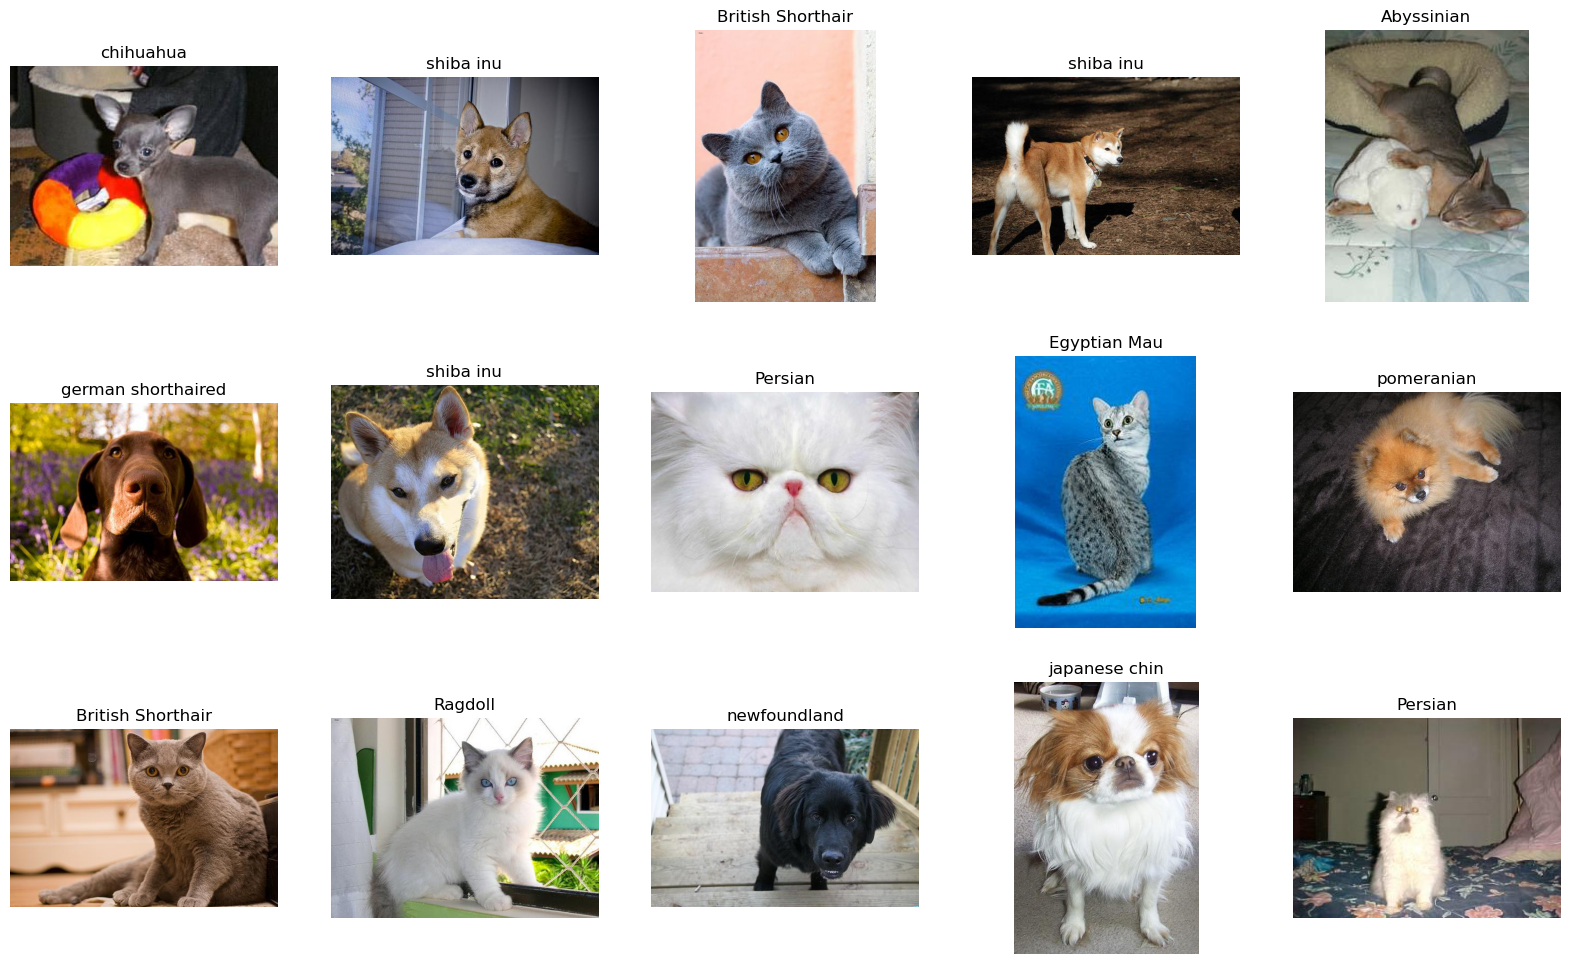

In [7]:
show_samples(dataset['train'], rows=3, cols=5)

#### Preprocessing the dataset

In [8]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

In [9]:
our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [10]:
# map the labels to integer counterparts (0 to 36)
label2id = {c:idx for idx, c in enumerate(labels)}
id2label = {idx:c for idx, c in enumerate(labels)}

#### Image Processor

using AutoImageProcessor which will apply the transforms according to the model we will use.

In [11]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

c:\Users\ahsam\anaconda3\envs\dl_env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ahsam\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [12]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

At the time of training, we need to apply the transforms on a batch of samples. To handle the batches, we'll create a `transforms` function which will take care of the following:

- Converting all images into RGB: It might be possible that some images in your dataset will be grayscale or transparent (RGBA).
- Converting the string labels to integers: using the `label2id` map.
- Applying image transforms: we pass the images through the `processor` to process, and convert them into PyTorch format.

The resultant dataset features will be:
```py
{
    'pixel_values': torch.Tensor,
    'labels': List
}
```

We'll pair the function with our dataset using the `with_transform()` method.

In [13]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'], return_tensor='pt')
    inputs['labels'] = [label2id[y] for y in batch['label']]

In [14]:
processed_dataset = our_dataset.with_transform(transforms)

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for `labels`, the shape should be `(batch,)` 

In [15]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

#### Calculate the metrics

We can use Hugging Face `evaluate` library to calculate the metrics. For image classification, we can use the accuracy metric.

In [16]:
accuracy = evaluate.load('accuracy')
def compute_metric(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

#### Loading the model

We will use [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) to load our pre-trained model. 

We do need to update the final classification layer, to output predictions equal to the number of labels in our dataset. 
We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classification layer.

In [17]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes= True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [19]:
for name, p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

We can check how many parameters are there in the model along with how many are actually going to be trained now.

In [20]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f'{num_params = :,} | {trainable_params = :,}')

num_params = 85,827,109 | trainable_params = 28,453


#### Training the model